In [1]:
%%time
%load_ext autoreload
%autoreload 2

import sys
import os
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from gepdynamics import _utils
from gepdynamics import _constants
from gepdynamics import cnmf

# Move to the project's home directory, as defined in _constants
_utils.cd_proj_home()
print(os.getcwd())

/cs/labs/mornitzan/yotamcon/gep-dynamics
CPU times: user 2.72 s, sys: 980 ms, total: 3.7 s
Wall time: 7.13 s


In [2]:
import torch
assert torch.cuda.is_available()
device = 'cuda'

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


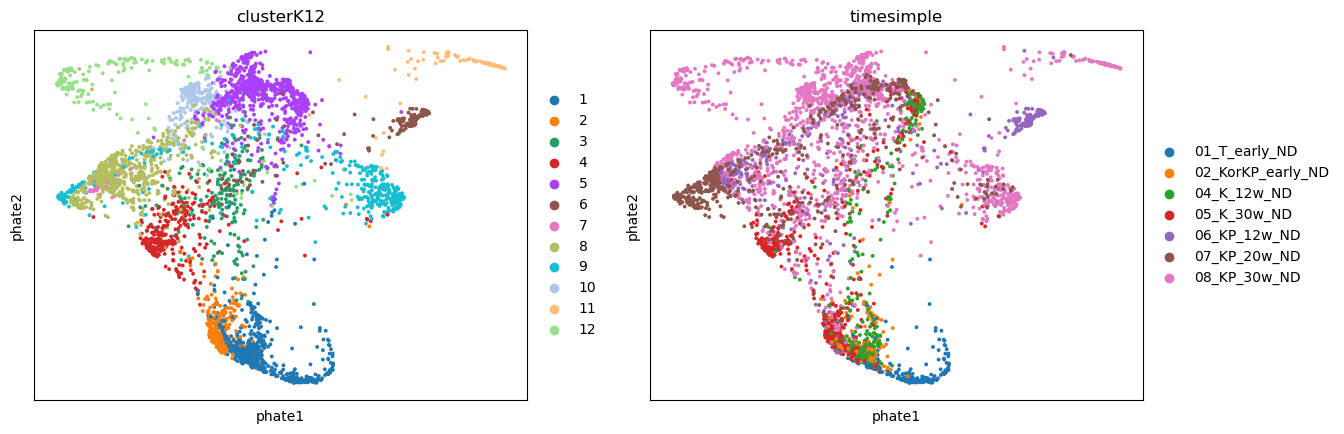

AnnData object with n_obs × n_vars = 3891 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'timesimple_colors', 'clusterK12_colors'
    obsm: 'X_phate', 'X_tsne'

In [3]:
results_dir = _utils.set_dir('results')
orig_adata_path = results_dir.joinpath('marjanovic_mmLungPlate.h5ad')
split_adatas_dir = _utils.set_dir(results_dir.joinpath('marjanovic_mmLungPlate_split'))

adata = sc.read(orig_adata_path)
sc.external.pl.phate(adata, color=['clusterK12', 'timesimple'])
adata

In [4]:
k_12 = sc.read_h5ad(split_adatas_dir.joinpath('04_K_12w_ND_GEPs.h5ad'))
k_12

AnnData object with n_obs × n_vars = 455 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusterK12_colors', 'cnmf_params', 'hvg', 'name', 'sname', 'timesimple_colors'
    obsm: 'X_phate', 'X_tsne', 'row_colors', 'usages', 'usages_norm'
    varm: 'usage_coefs'

In [5]:
k_30 = sc.read_h5ad(split_adatas_dir.joinpath('05_K_30w_ND_GEPs.h5ad'))
k_30

AnnData object with n_obs × n_vars = 505 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusterK12_colors', 'cnmf_params', 'hvg', 'name', 'sname', 'timesimple_colors'
    obsm: 'X_phate', 'X_tsne', 'row_colors', 'usages', 'usages_norm'
    varm: 'usage_coefs'

## Running pfNMF on K30 using the K12 GEPs

### Preparing K12 and K30 data on joint highly variable genes (jHVGs)


In [6]:
print("Number of joint HVGs for K12 and K30 datasets = "
      f"{np.sum(k_30.var.highly_variable & k_12.var.highly_variable)}")

Number of joint HVGs for K12 and K30 datasets = 735


In [7]:
joint_K12_K30_var = sc.pp.highly_variable_genes(
    adata[adata.obs.timesimple.isin([k_12.uns['name'], k_30.uns['name']])],
    flavor='seurat_v3', n_top_genes=_constants.NUMBER_HVG, inplace=False)
joint_K12_K30_var

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


,means,variances,highly_variable_rank,variances_norm,highly_variable
geneID,,,,,
ENSMUSG00000000001.4_Gnai3,194.888542,5.199244e+04,NaN,0.971857,False
ENSMUSG00000000028.14_Cdc45,5.904417,1.503283e+03,917.0,2.148386,True
ENSMUSG00000000031.15_H19,0.001042,1.041667e-03,NaN,1.002403,False
ENSMUSG00000000049.11_Apoh,0.008333,6.666667e-02,NaN,1.003878,False
ENSMUSG00000000056.7_Narf,27.791667,4.079177e+03,NaN,0.935093,False
...,...,...,...,...,...
ENSMUSG00000114960.1_AC115289.2,0.161219,1.055823e+01,1366.0,2.011522,True
ENSMUSG00000114967.1_AC161884.2,0.068750,1.169408e+00,NaN,1.127457,False
ENSMUSG00000114968.1_AC130217.2,0.745125,1.059286e+02,441.0,2.467911,True


In [8]:
print("Selecting 2000 joint HVGs, intersection with K12 HVGS is "
      f"{np.sum(joint_K12_K30_var.highly_variable & k_12.var.highly_variable)}"
      ", and with K30 is "
      f"{np.sum(joint_K12_K30_var.highly_variable & k_12.var.highly_variable)}")

Selecting 2000 joint HVGs, intersection with K12 HVGS is 1144, and with K30 is 1144


In [9]:
# Variance normalized version of K12 data on the jHVGs
X12 = sc.pp.scale(k_12.X[:, joint_K12_K30_var.highly_variable].toarray(), zero_center=False)
X12[:4, :4]

array([[0.        , 0.01119922, 0.        , 0.        ],
       [0.        , 0.24478301, 0.        , 0.        ],
       [0.        , 0.9135366 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [10]:
# Variance normalized version of K30 data on the jHVGs
X30 = sc.pp.scale(k_30.X[:, joint_K12_K30_var.highly_variable].toarray(), zero_center=False)
X30[:4, :4]

array([[1.8623625 , 0.06579945, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.33265278, 0.        , 0.        ]], dtype=float32)

### Running NNLS to get K12 GEPs (geps12) on jHVGs

In [23]:
# Working in the transposed notation to get the programs: X.T ~ H.T @ W.T

nmf_kwargs={'H': k_12.obsm['usages'].T.copy(),
            'update_H': False,
            'tol': _constants.NMF_TOLERANCE,
            'n_iter': 500,
            'beta_loss': 'kullback-leibler'
           }

tens = torch.tensor(X12.T).to(device)

W, H, n_iter = cnmf.nmf_torch(X12.T, nmf_kwargs, tens, verbose=True)

del tens

geps12 = W.T
geps12.shape

beta 1 loss = 281304.0625, # iterations was 40


(6, 2000)

### Decomposing K30 with geps12 and 0 additional programs

In [24]:
#  x30 ~ W @ geps12

nmf_kwargs={'H': geps12.copy(),
            'update_H': False,
            'tol': _constants.NMF_TOLERANCE,
            'n_iter': 500,
            'beta_loss': 'kullback-leibler'
           }

tens = torch.tensor(X30).to(device)

W, H, n_iter = cnmf.nmf_torch(X30, nmf_kwargs, tens, verbose=True)

del tens

beta 1 loss = 408783.4375, # iterations was 50


In [33]:
#  x30 ~ W @ geps12

nmf_kwargs={
    'n_components': 6,
    'tol': _constants.NMF_TOLERANCE,
    'n_iter': 500,
    'beta_loss': 'kullback-leibler'
   }

tens = torch.tensor(X30).to(device)

W, H, n_iter = cnmf.nmf_torch(X30, nmf_kwargs, tens, verbose=True)

del tens

beta 1 loss = 318910.9375, # iterations was 200
